# Notebook to make Fig. 2

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from fig_helper_functions import *

style.use('plotting.mplstyle')

import sys
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

### Data for true underlying populations

Load data

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

Make KDEs for spin parameters of underlying populations

In [3]:
# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)
chieff_grid =  np.linspace(-1,1,500)
chip_grid =  np.linspace(0,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # spin magnitude
    chi1 = np.sqrt(pop.s1x**2 + pop.s1y**2 + pop.s1z**2)
    chi2 = np.sqrt(pop.s2x**2 + pop.s2y**2 + pop.s2z**2)
    chi = np.concatenate((chi1,chi2))
    chi_kde = gaussian_kde(chi)(chi_grid) + gaussian_kde(2-chi)(chi_grid) + gaussian_kde(-chi)(chi_grid)
    
    # tilt angle
    cost1 = pop.s1z/chi1
    cost2 = pop.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    cost_kde = gaussian_kde(cost)(cost_grid) + gaussian_kde(2-cost)(cost_grid) + gaussian_kde(-2-cost)(cost_grid)
    
    # chi effective
    q = pop.m2/pop.m1
    chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
    chieff_kde = gaussian_kde(chieff)(chieff_grid) + gaussian_kde(2-chieff)(chieff_grid) + gaussian_kde(-1-chieff)(chieff_grid)
    
    # chi p
    sint1 = np.sin(np.arccos(cost1))
    sint2 = np.sin(np.arccos(cost2))
    chip = calculate_chiP(chi1, chi2, sint1, sint2, q)
    chip_kde = gaussian_kde(chip)(chip_grid) + gaussian_kde(2-chip)(chip_grid) + gaussian_kde(-chip)(chip_grid)
    
    # put KDEs into dict
    kde_dict[pop_key] = {
        'chi':chi_kde, 
        'cost':cost_kde, 
        'chieff':chieff_kde, 
        'chip':chip_kde
    }

### Load `emcee` hierarchical inference results

Load data

In [4]:
# For loading files
model = 'betaPlusDoubleGaussian'
pops = ['1', '2', '3']
nevents = ['70', '300'] 
date = '092823'

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        
        print(pop, nevent)
        
        name = f"../Data/PopulationInferenceOutput/{model}/{date}_{model}_pop{pop}_{nevent}events.json"
        
        with open(name, 'r') as f:
            data = json.load(f)
            
        data_pop[nevent+' events'] = data    
            
    data_dict['pop '+pop] = data_pop

1 70
1 300
2 70
2 300
3 70
3 300


Make dict containing all the traces to plot

In [5]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations and numbers of events
for pop in pops: 
    
    pop_key = 'pop '+pop
    traces_pop = {}

    print(pop_key)
    
    for nevent in nevents: 
                    
        # Fetch data
        nevent_key = nevent+' events'
        data = data_dict[pop_key][nevent_key]
        
        # Instantiate an array to hold a collection of traces
        nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
        p_chi = np.zeros((nTraces,chi_grid.size))
        p_cost = np.zeros((nTraces,cost_grid.size))
        p_chieff = np.zeros((nTraces,chieff_grid.size))
        p_chip = np.zeros((nTraces,chip_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
        for i,ind in enumerate(random_indices):
            
            print(i, end='\r')

            mu_chi = data['mu_chi']['processed'][ind]
            sigma_chi = data['sigma_chi']['processed'][ind]
            mu1_cost = data['mu1_cost']['processed'][ind]
            sigma1_cost = data['sigma1_cost']['processed'][ind]
            mu2_cost = data['mu2_cost']['processed'][ind]
            sigma2_cost = data['sigma2_cost']['processed'][ind]
            MF_cost = data['MF_cost']['processed'][ind]
            Bq = data['Bq']['processed'][ind]

            # calculate gaussian distribution for chi
            a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
            p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

            # and gaussian distribution for cos(theta)
            p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
            
            # generate corresponding distribution for chi_eff and chi_p
            chi_effs, chi_ps = draw_chiEffs_and_chiPs_betaDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, 
                                                                      mCut=8, n=500)
            
            chieff_kde = gaussian_kde(chi_effs)
            p_chieff[i,:] = chieff_kde(chieff_grid)
            
            chip_kde = gaussian_kde(chi_ps)
            p_chip[i,:] = chip_kde(chip_grid)
            
        # Add to dict 
        traces_pop[nevent_key] = {'p_chi':p_chi, 'p_cost':p_cost, 'p_chieff':p_chieff, 'p_chip':p_chip} 
        
    traces_dict[pop_key] = traces_pop

pop 1


/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


pop 2
pop 3


### Make figure

In [6]:
# Labels corresponding to each pop
labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '70 events':'#8fbcda', 
    '300 events':'#196090'
}

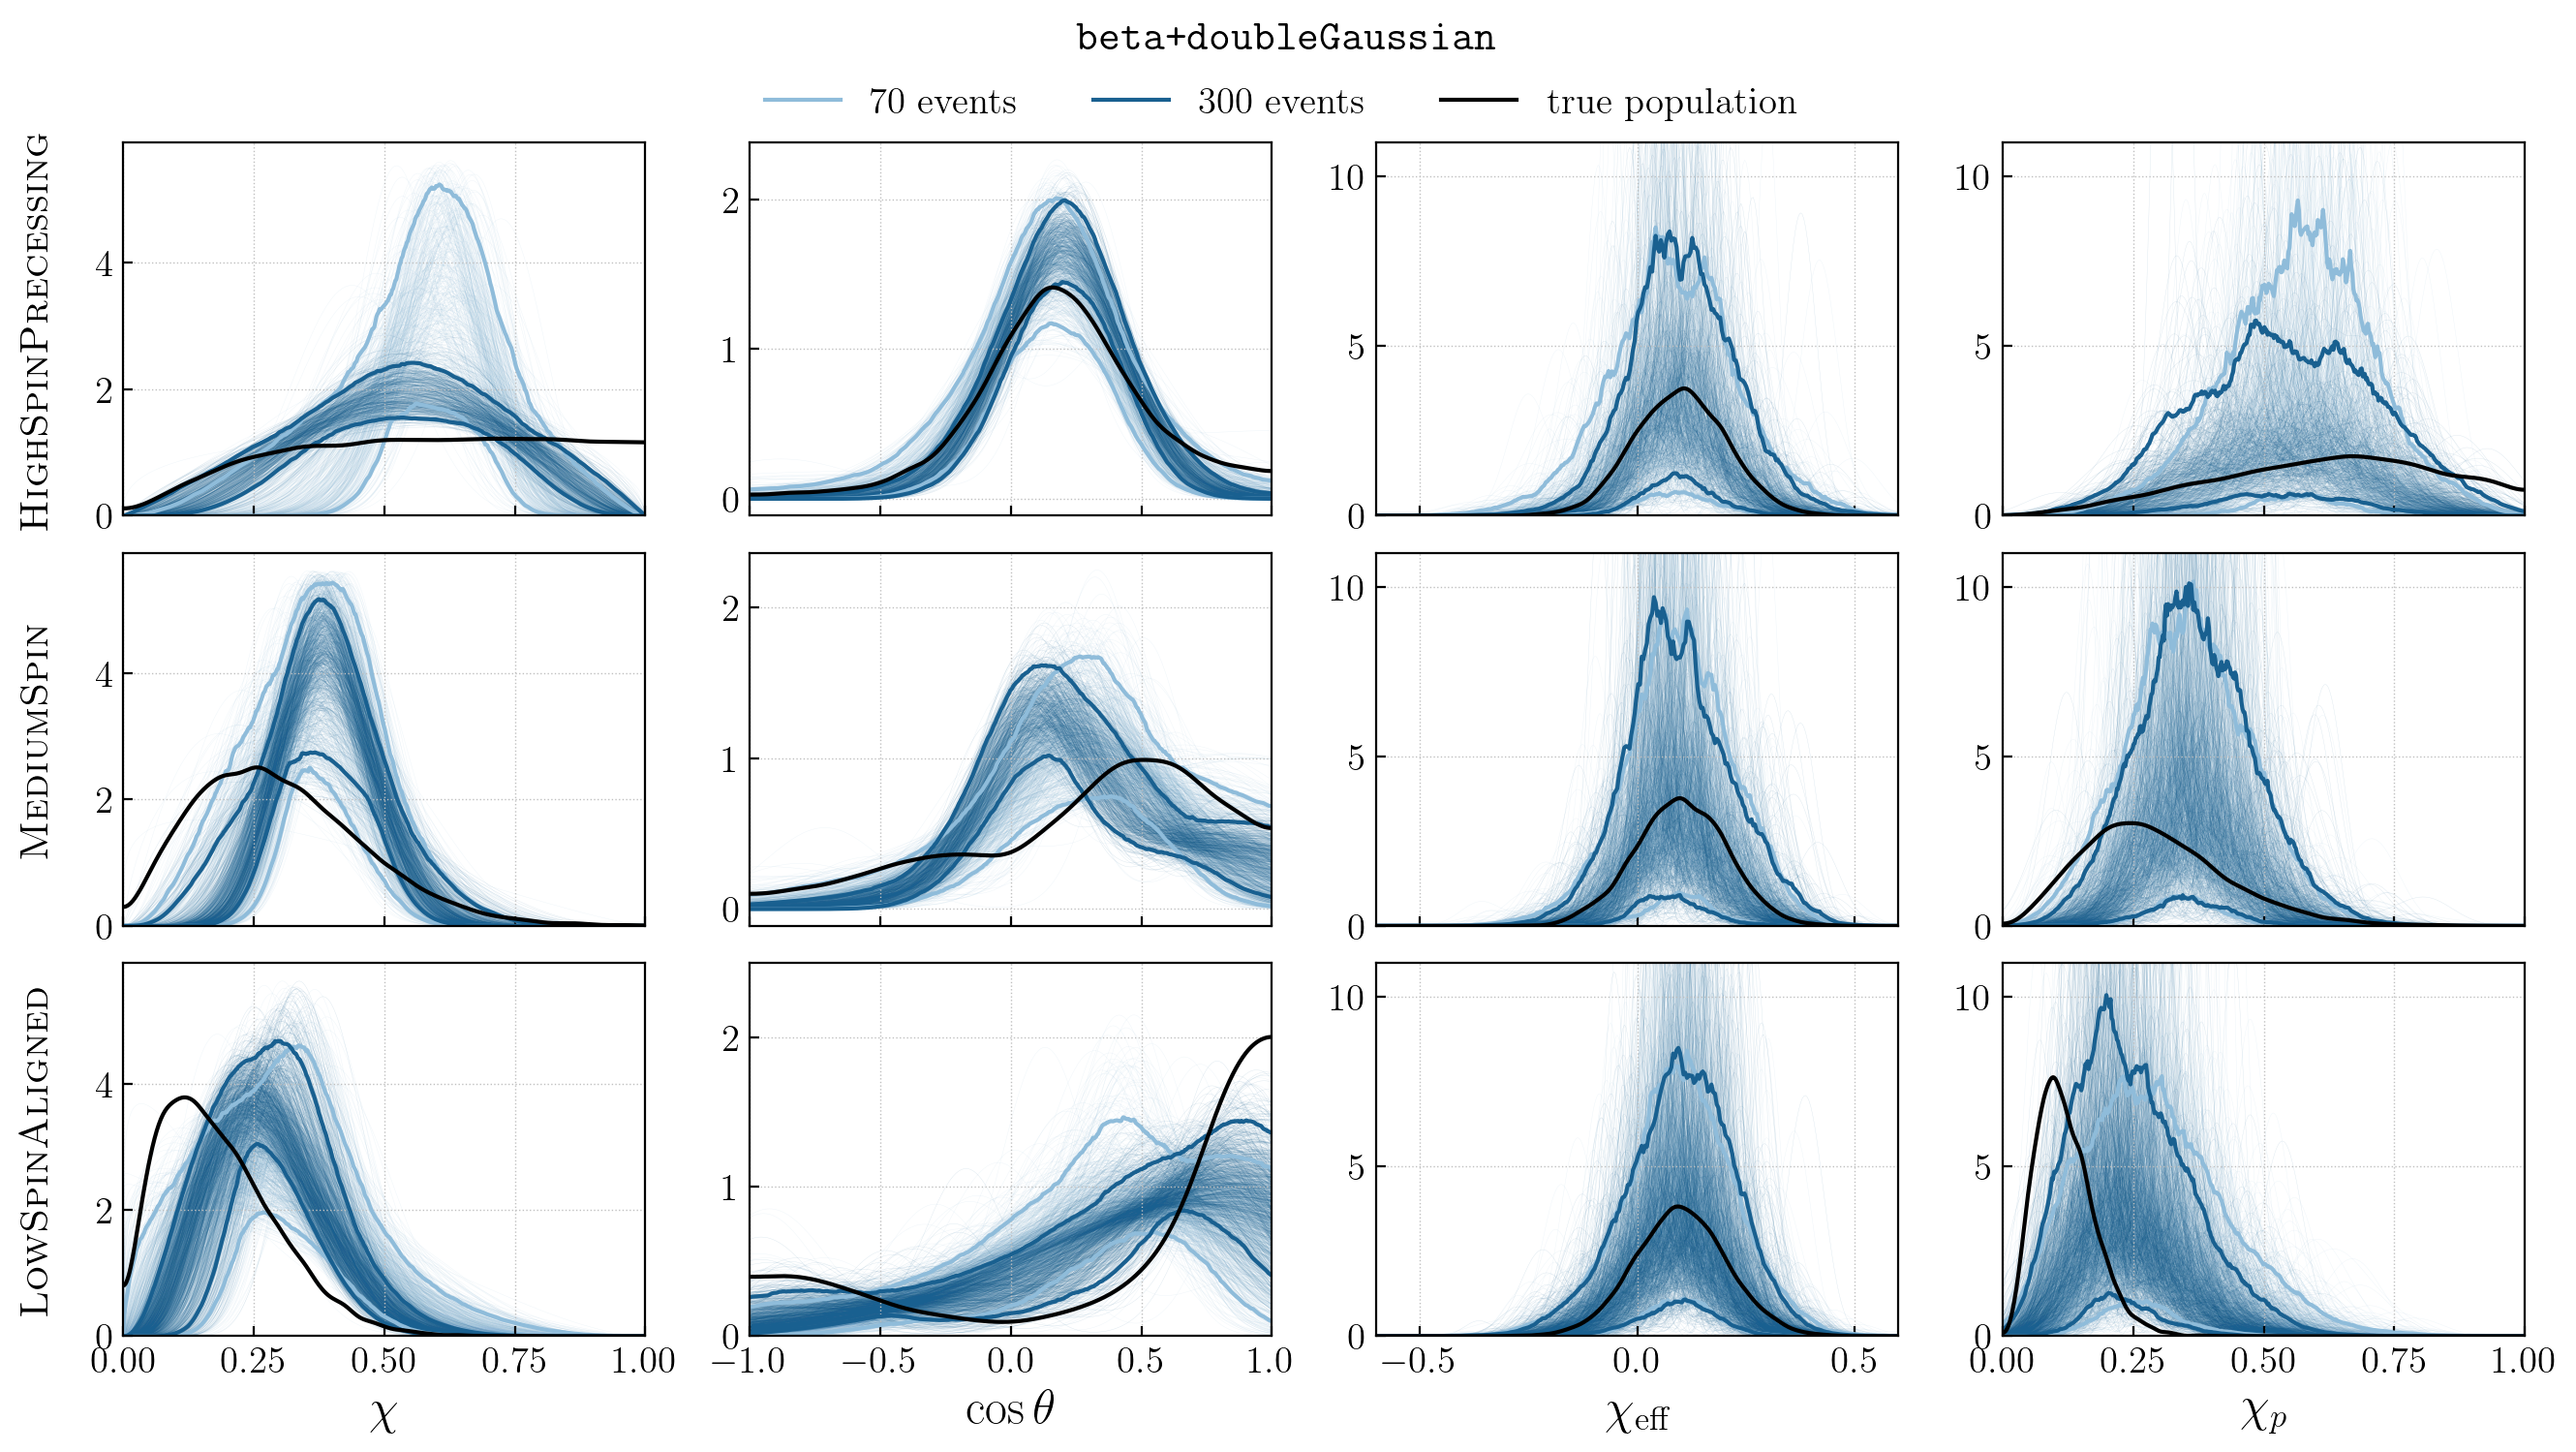

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,8))

for ax in axes: 
    for a in ax: 
        a.set_rasterization_zorder(2)

for i,pop_key in enumerate(kde_dict):
    for nevent in nevents: 
        nevent_key = nevent+' events'
        
        ## Plot traces from hyperposteriors + 5% and 95% credible bounds

        # spin magnitude
        p_chi = traces_dict[pop_key][nevent_key]['p_chi']
        axes[i][0].plot(chi_grid, p_chi.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=1)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.05,axis=0), color=nevents_colors_dict[nevent_key], label=nevent_key)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.95,axis=0), color=nevents_colors_dict[nevent_key])

        # tilt angle
        p_cost = traces_dict[pop_key][nevent_key]['p_cost']
        axes[i][1].plot(cost_grid, p_cost.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=1)
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=nevents_colors_dict[nevent_key])
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=nevents_colors_dict[nevent_key])
        
        # chi effective
        p_chieff = traces_dict[pop_key][nevent_key]['p_chieff']
        axes[i][2].plot(chieff_grid, p_chieff.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=1)
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.05,axis=0), color=nevents_colors_dict[nevent_key])
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.95,axis=0), color=nevents_colors_dict[nevent_key])

        # chi p
        p_chip = traces_dict[pop_key][nevent_key]['p_chip']
        axes[i][3].plot(chip_grid, p_chip.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=1)
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.05,axis=0), color=nevents_colors_dict[nevent_key])
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.95,axis=0), color=nevents_colors_dict[nevent_key])
        
       
    ## Plot injected dists 
    
    # spin magnitude
    axes[i][0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', label='true population')
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,)
    
    # tilt angle
    axes[i][1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k')
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    axes[i][2].plot(chieff_grid, kde_dict[pop_key]['chieff'], color='k')
    axes[i][2].set_xlim(-0.6,0.6)
    axes[i][2].set_ylim(0,11)
    
    # chi p
    axes[i][3].plot(chip_grid, kde_dict[pop_key]['chip'], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,11)
    
    # set label
    axes[i][0].set_ylabel(labels_dict[pop_key], fontsize=15, labelpad=15)
    
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])

# x-axis labels
axes[2][0].set_xlabel(r'$\chi$')
axes[2][1].set_xlabel(r'$\cos\theta$')
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$')
axes[2][3].set_xlabel(r'$\chi_p$')  

# Specific x limits for some 
#axes[1][1].set_ylim(0,2)
axes[2][1].set_ylim(0,2.5)

# Add legend
axes[0][0].legend(bbox_to_anchor=(1.2, 1.02, 1., .102), loc='lower left',ncol=3,  borderaxespad=0.)
for ax in axes: 
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        
plt.subplots_adjust(hspace=0.1)

plt.suptitle(r'$\mathrm{\texttt{beta+doubleGaussian}}$', fontsize=16, y=0.96)
    
plt.savefig('figure_02.pdf',bbox_inches='tight')
plt.show()